<a href="https://colab.research.google.com/github/Equipe16-IAA/IAA009---Deep-Learning/blob/main/GAN/GAN_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalar bibliotecas para geração de GIFs



In [18]:
# Para gerar os GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-45a04our
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-45a04our
  Resolved https://github.com/tensorflow/docs to commit 460419a6369bd00bfc3ce7a7c92b0ca2a832c91b
  Preparing metadata (setup.py) ... done


##Importações das bibliotecas necessárias

In [19]:
# Importações
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Tratamento da base

In [20]:
# Carrega a base de dados
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalização
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normaliza entre [-1, 1]

# Gera o banco em partes e randomiza
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Cria o dataset (from_tensor_slices)
# shuffle: embaralha os dados
# Combina elementos consecutivos em lotes (batch)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Gerador de imagens

In [21]:
# Cria o gerador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None é o batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

## Teste do Gerador

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


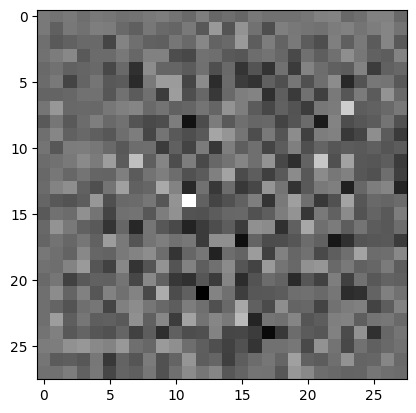

In [22]:
# Teste do gerador ainda não treinado
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


## Criação do discriminador

In [23]:
# Cria o DISCRIMINADOR
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

## Teste do Discriminador

In [24]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00073071]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Funções de perda - Pré-step treinamento

In [25]:
# Definição das funções de perda
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Função de perda do discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Função de perda do gerador
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Criação dos otimizadores

In [26]:
# Cria os otimizadores para o gerador e discriminador
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [27]:
# Cria checkpoints para salvar modelos ao longo do tempo
# Úteis em tarefas longas, para se recuperar em um desligamento
checkpoint_dir = './training_checkpoints'
checkpoint_prefix =  os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Configura o loop de treinamento
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# Seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Verificação dos gradientes

In [28]:
def f(x,y):
  return 3*x**2 + 2*y**2

x,y = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
  z = f(x,y)
gradients = tape.gradient(z, [x,y])
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, <tf.Tensor: shape=(), dtype=float32, numpy=12.0>]


## Passo de Treinamento

In [29]:
# Função que faz um passo de treinamento
# É uma 'tf.function', que compila essa função
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## Loop de treinamento

In [35]:
# Treinamento completo/laço
def train (dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      # Produz imagens do GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Salva o modelo a cada 15 epocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Gera depois da epoca final
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Salvamento de Imagens

In [36]:
# Gerar e Salvar Imagens
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Treinamento

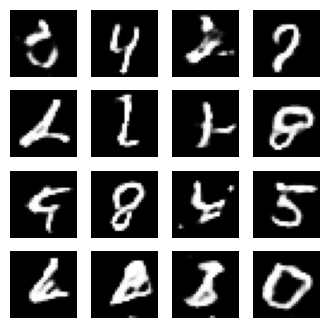

In [37]:
# Treinar o modelo e restaurar o último ponto de verificação
train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Criação do GIF

<ipython-input-38-2bcca84eb4d6>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-38-2bcca84eb4d6>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



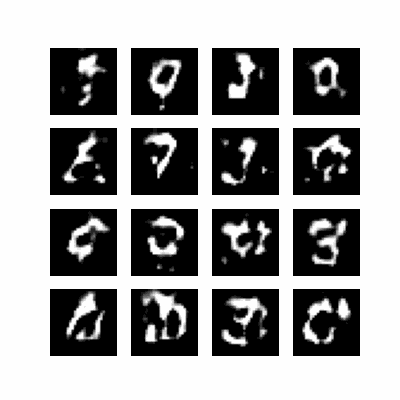

In [38]:
# Criar m GIF

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)